# Robustness for varied output sparsities

In [1]:
import torch
import copy
import umap
import argparse
import numpy as np
from numpy import genfromtxt
import difflib
import matplotlib
import networkx as nx
import community
from matplotlib import colors
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Setting plot parameters

SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 24

greens = plt.get_cmap('Greens')
purples = plt.get_cmap('Purples')
greys = plt.get_cmap('Greys')
viridis = plt.get_cmap('viridis')
pastel = plt.get_cmap('Pastel2',5)
plt.rc('lines',linewidth=2)
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE-2 , frameon=False)    # legend fontsize
plt.rc('text', usetex=False)
#plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rcParams.update({'axes.spines.top': True, 'axes.spines.right': True})
plt.rcParams['pdf.fonttype'] = 42

### Specify parameters

In [3]:
device = torch.device('cpu')
N = 100 # No. of input nodes i.e. behaviours
M = N # No. of motor units, output
response_threshold = 0.5 # Whether an input corresponds to activating the node or not
loss_series = []

In [4]:
x_in = [[1 if i==j else 0 for i in range(N)] for j in range(N)]
x = torch.tensor(x_in).float()

In [8]:
N = 100
M = 100
ks = np.round(np.linspace(5, 50, 10))
Rs = np.linspace(0, M, 11)[1:]

### Helper functions

In [6]:
# Activation function
def actfn(x):
    y = x.sigmoid()
    return y

In [7]:
def prediction (x, b1, b2, w1, w2):
    y_pred = actfn(actfn(x.mm(w1)+b1).mm(w2)+b2)
    y_pred_binary = np.abs(np.round(y_pred.data.numpy()))
    
    return y_pred_binary

In [8]:
# Adding an activated unit
activated_units = 1
x_act = torch.zeros((N,N+activated_units))
for i in range(len(x)):
    x_act[i] = torch.cat((x[i],torch.ones(activated_units,dtype=torch.float32)))

In [9]:
def affect (R, N, activated_units, b1, b2, w1, w2, y_pred_binary):

    motor_units = [[] for i in range(len(y_pred_binary))] # Which hidden neurons affect each motor unit
    hidden_affected = np.zeros(R) # No. of behaviours affected by each hidden neuron
    MI = []
    stereotypy = []
    
    for i in range(R):
        activated_hidden = torch.zeros(R)
        activated_hidden[i] = 1000
    
        w_act = torch.zeros((N+activated_units, R))
        for j in range(len(w_act)):
            if j < N:
                w_act[j] = w1[j]
            else:
                w_act[j] = activated_hidden
            
        # Modified predictions of the NN
        y_pred_2 = actfn(actfn(x_act.mm(w_act)+b1).mm(w2)+b2)
        y_pred_2 = y_pred_2.detach().numpy()
        y_pred_2 = np.abs(np.round(y_pred_2))  # Threshold = 0.5
        comparison_array = (y_pred_2)*2 + y_pred_binary
    
        for k in range(len(comparison_array)):
            for indx, comp in enumerate(comparison_array[k]):
                if comp == 1 or comp == 2:
                    motor_units[indx].append(i+1)
                    
        # Number of behaviours each hidden neuron affects
        for k in range(len(comparison_array)):
            for indx, comp in enumerate(comparison_array[k]):
                if comp == 1 or comp == 2:
                    hidden_affected[i] += 1
                    break
                    
        # Calculate the mutual information
        stim_status = np.zeros(N)
        
        for i in range(N):
            if np.array_equal(y_pred_2[i], y_pred_binary[i]):
            #s = difflib.SequenceMatcher(None, y_pred_2[i],y_pred_binary[i])
            #if s.ratio() > 0.99:
                stim_status[i] += 1
            else:
                modified_indices = [j for j in range(N) if j!=i]
                for k in modified_indices:
                    #s = difflib.SequenceMatcher(None, y_pred_2[i],y_pred_binary[k])
                    #if s.ratio() > 0.99:
                    if np.array_equal(y_pred_2[i], y_pred_binary[k]):
                        stim_status[k] += 1
                        
        non_zero = np.nonzero(stim_status)
        final_stim_status = stim_status[non_zero]
        stereotyped_inputs = np.where(final_stim_status > 1)[0]
        stereotypy.append(sum(final_stim_status[stereotyped_inputs]))
        MI.append(sum((final_stim_status/N)*np.log2(N/final_stim_status)))
           
    n = (sum(hidden_affected)/R)
    avg_unaffected_behaviours = N-n
    MI_avg = (sum(MI)/R)
    stereotypy_avg = (sum(stereotypy)/R)
    
    return avg_unaffected_behaviours, MI_avg, stereotypy_avg, hidden_affected

In [10]:
def affected_mean (R_list, affected_bhv_list):

    bhv_mean = np.zeros(len(R_list))
    bhv_std = np.zeros(len(R_list))

    for i in range(len(R_list)):
        bhv_mean[i] = np.mean(np.array(affected_bhv_list[i]))
        bhv_std[i] = np.std(np.array(affected_bhv_list[i]))
    return bhv_mean, bhv_std

## Compute robustness

### k = 5 to 50, R = 10, ..., 100

In [15]:
bhv_mean_all = []
bhv_std_all = []
for k_ind, k in enumerate(ks):
    unaffected_bhv_list = []

    for R_ind, R in enumerate(Rs):
        R = int(R)
        tmp = []
        
        for it_ind in range(5):
            print(it_ind)
            model = torch.nn.Sequential(
              torch.nn.Linear(N, R),
              torch.nn.Sigmoid(),
              torch.nn.Linear(R,M),
              torch.nn.Sigmoid())
            model.load_state_dict(torch.load('k_var_models/k{}_R{}_it{}'.format(k_ind, R_ind, it_ind)))
            trained_parameters = []
            for param in model.named_parameters():
                trained_parameters.append(param[1])

            w1 = trained_parameters[0]
            b1 = trained_parameters[1]
            w2 = trained_parameters[2]
            b2 = trained_parameters[3]
                
            y_pred_binary = prediction (x, b1, b2, w1.T, w2.T)
            avg_unaffected_behaviours, _, _, _ = affect (R, N, activated_units, b1, b2, w1.T, w2.T, y_pred_binary)
            tmp.append(avg_unaffected_behaviours)
        unaffected_bhv_list.append(tmp)
        
    bhv_mean, bhv_std = affected_mean(Rs, unaffected_bhv_list)
    bhv_mean_all.append(bhv_mean)
    bhv_std_all.append(bhv_std)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


### k = 5 to 50, R = 1

In [54]:
bhv_mean_all_new = np.zeros((10, 11))
bhv_std_all_new = np.zeros((10, 11))
for k_ind, k in enumerate(ks):

    R=1
    R_ind = 0
    tmp = []
        
    for it_ind in range(5):
        print(it_ind)
        model = torch.nn.Sequential(
          torch.nn.Linear(N, R),
          torch.nn.Sigmoid(),
          torch.nn.Linear(R,M),
          torch.nn.Sigmoid())
        model.load_state_dict(torch.load('k_var_models/k{}_R{}0_it{}'.format(k_ind, R_ind, it_ind)))
        trained_parameters = []
        for param in model.named_parameters():
            trained_parameters.append(param[1])

        w1 = trained_parameters[0]
        b1 = trained_parameters[1]
        w2 = trained_parameters[2]
        b2 = trained_parameters[3]

        y_pred_binary = prediction (x, b1, b2, w1.T, w2.T)
        avg_unaffected_behaviours, _, _, _ = affect (R, N, activated_units, b1, b2, w1.T, w2.T, y_pred_binary)
        tmp.append(avg_unaffected_behaviours)
    unaffected_bhv_list=[tmp]
        
    bhv_mean, bhv_std = affected_mean(Rs, unaffected_bhv_list)
    bhv_mean_all_new[k_ind] = np.insert(bhv_mean_all[k_ind],0, bhv_mean)
    bhv_std_all_new[k_ind] = np.insert(bhv_std_all[k_ind],0, bhv_std)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


### k = 5, R = 2, 5

In [95]:
k_ind = 0
R=5
R_ind = 0
tmp5 = []
for it_ind in range(5):
    print(it_ind)
    model = torch.nn.Sequential(
      torch.nn.Linear(N, R),
      torch.nn.Sigmoid(),
      torch.nn.Linear(R,M),
      torch.nn.Sigmoid())
    model.load_state_dict(torch.load('k_var_models/k{}_R{}0_5_it{}'.format(k_ind, R_ind, it_ind)))
    trained_parameters = []
    for param in model.named_parameters():
        trained_parameters.append(param[1])

    w1 = trained_parameters[0]
    b1 = trained_parameters[1]
    w2 = trained_parameters[2]
    b2 = trained_parameters[3]

    y_pred_binary = prediction (x, b1, b2, w1.T, w2.T)
    avg_unaffected_behaviours, _, _, _ = affect (R, N, activated_units, b1, b2, w1.T, w2.T, y_pred_binary)
    tmp5.append(avg_unaffected_behaviours)

0
1
2
3
4


In [95]:
k_ind = 0
R=2
R_ind = 0
tmp2 = []
for it_ind in range(5):
    print(it_ind)
    model = torch.nn.Sequential(
      torch.nn.Linear(N, R),
      torch.nn.Sigmoid(),
      torch.nn.Linear(R,M),
      torch.nn.Sigmoid())
    model.load_state_dict(torch.load('k_var_models/k{}_R{}0_2_it{}'.format(k_ind, R_ind, it_ind)))
    trained_parameters = []
    for param in model.named_parameters():
        trained_parameters.append(param[1])

    w1 = trained_parameters[0]
    b1 = trained_parameters[1]
    w2 = trained_parameters[2]
    b2 = trained_parameters[3]

    y_pred_binary = prediction (x, b1, b2, w1.T, w2.T)
    avg_unaffected_behaviours, _, _, _ = affect (R, N, activated_units, b1, b2, w1.T, w2.T, y_pred_binary)
    tmp2.append(avg_unaffected_behaviours)

0
1
2
3
4


## Plot and save data

In [7]:
from numpy import genfromtxt
import seaborn as sns
sns.set_palette("coolwarm", 10)

In [17]:
np.savetxt("robustness_avg.csv", bhv_mean_all, delimiter=",")
np.savetxt("robustness_std.csv", bhv_std_all, delimiter=",")

In [11]:
Rs_plot = np.insert(Rs, 0, 1)
k5_mean = [np.mean(tmp[:5])/100, np.mean(tmp2)/100, np.mean(tmp5)/100]
k5_std = [np.std(tmp[:5])/2/100, np.std(tmp2)/2/100, np.std(tmp5)/2/100]
Rk5 = [1, 2, 5]
for i in range(1, 11):
    k5_mean.append(bhv_mean_all_new[0][i]/100)
    k5_std.append(bhv_std_all_new[0][i]/100)
    Rk5.append(Rs_plot[i])
    
np.savetxt("robustness_avg_k5.csv", k5_mean, delimiter=",")
np.savetxt("robustness_std_k5.csv", k5_std, delimiter=",")

np.savetxt("robustness_avg_kall.csv", bhv_mean_all_new, delimiter=",")
np.savetxt("robustness_std_kall.csv", bhv_std_all_new, delimiter=",")

### Load data

In [13]:
bhv_mean_all_new = genfromtxt('robustness_avg_kall.csv', delimiter=',')
bhv_std_all_new = genfromtxt('robustness_std_kall.csv', delimiter=',')
k5_mean = genfromtxt('robustness_avg_k5.csv', delimiter=',')
k5_std = genfromtxt('robustness_std_k5.csv', delimiter=',')

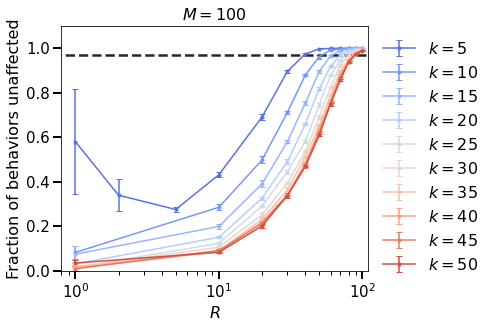

In [15]:
plt.figure(figsize=(5.5,4.5))
plt.errorbar(Rk5, k5_mean, k5_std, 
             linewidth = 1.5, capsize=3, marker ='.', label = r'$k = {}$'.format(int(ks[0])))

for k_ind, k in enumerate(ks):
    if k_ind > 0:
        plt.errorbar(np.array(Rs_plot), bhv_mean_all_new[k_ind]/100, bhv_std_all_new[k_ind]/100, capsize=3, 
                     linewidth = 1.5, marker ='.', label = r'$k = {}$'.format(int(k)))
plt.plot(np.linspace(0, 250, 50), 0.97*np.ones(50), '--', color = 'black', linewidth = 2.5, alpha = 0.85)
plt.xlabel('$R$')
plt.tick_params('both', length=8, width=2, which='major')
plt.tick_params('both', length=4, width=1, which='minor')
plt.ylabel('Fraction of behaviors unaffected', fontsize=16)
plt.tick_params(labelsize=15)
plt.title('$M = 100$', fontsize=16)
plt.xlim([0.8, 10**2*1.1])
plt.ylim([0, 1.1])
plt.semilogx()
plt.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor = [1, 1])
plt.savefig('kvar_robust.pdf', bbox_inches='tight')
plt.show()